# Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

Load it in grayscale.

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory('data/covid/train/', color_mode='grayscale', shuffle=False)
val_ds = tf.keras.utils.image_dataset_from_directory('data/covid/validation/', color_mode='grayscale', shuffle=False)
test_ds = tf.keras.utils.image_dataset_from_directory('data/covid/test/', color_mode='grayscale', shuffle=False)

Found 339 files belonging to 3 classes.
Found 42 files belonging to 3 classes.
Found 45 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
class_names

['COVID-19', 'HEALTHY', 'PNEUMONIA']

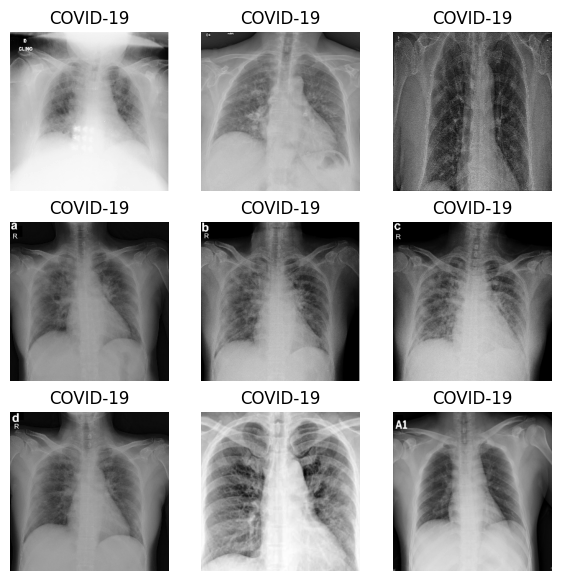

In [6]:
# Display image samples
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [5]:
# Image shapes
images[i].shape

TensorShape([256, 256, 1])

# Classical ML

For working with classical ML algorithms we need some kind of matrix or DataFrame format for representing the features.

The function below transforms images to a pandas DataFrame.

In [7]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [44]:
# Perform a single train-validation split
ss = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=42)

In [45]:
# Declare scores to be used
scoring = {
    'Bacc': make_scorer(balanced_accuracy_score),
    'Prec': make_scorer(precision_score, average='micro'),
    'Rec': make_scorer(recall_score, average='micro')
}

In [46]:
def print_rs_metrics(rs_model):
    for t in ['train', 'test']:
        if t == 'test':
            print('Validation\n---------------')
        else:
            print('Train\n---------------')
        print('Balanced Acc:', rs_model.cv_results_[f'mean_{t}_Bacc'][rs_model.best_index_].round(2))
        print('Recall:', rs_model.cv_results_[f'mean_{t}_Rec'][rs_model.best_index_].round(2))
        print('Precision:', rs_model.cv_results_[f'mean_{t}_Prec'][rs_model.best_index_].round(2))
        print()

In [47]:
def get_images_df(image_dataset):
    # get images from dataset in DF format
    df = []
    all_labels = []
    for images, labels in image_dataset:
        for img in images:
            flat_img = tf.keras.preprocessing.image.img_to_array(img, data_format=None, dtype=None).flatten()
            df.append(flat_img)
        all_labels.extend(labels.numpy())
    df = pd.DataFrame(df)
    df['label'] = all_labels
    return df

In [48]:
# Convert train, validation and test images to DF
df_train = get_images_df(train_ds)
df_val = get_images_df(val_ds)
df_test = get_images_df(test_ds)

In [49]:
print(df_train.shape)
df_train.head()

(339, 65537)


,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,133.446396,124.478516,116.227005,117.622932,115.250984,114.443260,115.816406,114.301094,116.669922,118.816406,...,232.000000,229.224304,227.000000,224.091705,222.182617,220.000000,216.635529,211.085938,254.000000,0
1,50.556885,51.687500,50.000000,49.664307,49.062256,50.000000,50.000000,49.103760,49.000000,48.830811,...,162.312500,158.583740,157.260498,155.089844,157.625244,155.312500,152.222656,153.933594,150.241699,0
2,41.938568,47.705780,52.086197,54.049973,58.179764,55.633804,59.620987,53.624222,57.861038,53.714249,...,94.434967,78.643753,84.353516,78.782211,82.050629,70.695786,71.030334,84.028748,87.266510,0
3,11.279842,12.771484,12.028118,9.754784,12.468697,12.794781,11.542667,12.769428,15.005844,11.304844,...,9.631351,10.486698,9.000000,9.000000,10.000000,11.000000,11.000000,11.000000,8.529297,0
4,0.232422,0.505272,4.974266,2.320724,0.117378,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.289062,251.644531,0


In [50]:
# We can subsample the train data to train faster
df_train_sub = df_train.sample(100, random_state=42)
X_train = df_train_sub.drop('label', axis=1)
y_train = df_train_sub['label']

X_val = df_val.drop('label', axis=1)
y_val = df_val['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(100, n_jobs=-1)

params = {
    # 'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [5, 10, 20, 30],
    'max_depth': [5, 8, 10, 20],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9],
    'max_samples': [None, 0.5, 0.7, 0.9],
    'max_leaf_nodes': [None, 20, 50],
}

rf = RandomizedSearchCV(rf,
                        n_iter=25,
                        param_distributions=params,
                        scoring=scoring,
                        cv=ss,
                        refit='Bacc',
                        return_train_score=True,
                        n_jobs=-1)

rf.fit(X_train, y_train)

print('Best:')
print(rf.best_params_)

Best:
{'min_samples_split': 20, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_features': 0.7, 'max_depth': 5, 'criterion': 'log_loss'}


In [28]:
print_rs_metrics(rf)

Train
---------------
Balanced Acc: 0.98
Recall: 0.98
Precision: 0.98

Validation
---------------
Balanced Acc: 0.79
Recall: 0.8
Precision: 0.8



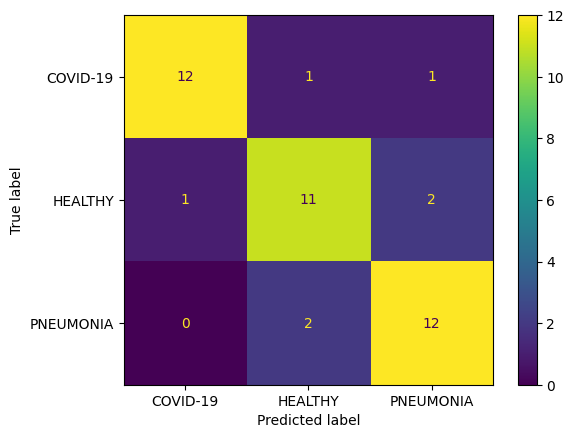

In [33]:
# Train best model on full train set
rf.best_estimator_.fit(X_train, y_train)

# Get predictions on validation set
y_val_preds = rf.best_estimator_.predict(X_val)

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_preds)
plt.xticks(range(3), class_names)
plt.yticks(range(3), class_names)
plt.show()

# CNN

## Grayscale

Keras can directly load data from a structure of directories, we don't need the pandas DataFrame we were using before.

The following example is not working well. Improve it! For example, adding more convolutional layer and/or more filters, etc.

In [10]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Rescaling, Dropout, BatchNormalization
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam

In [54]:
cnn_model = Sequential([
    Input(shape=(256, 256, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=5, strides=1, activation='relu'),
    MaxPooling2D(pool_size=3),
    Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [55]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model.fit(train_ds, validation_data=val_ds, epochs=100, batch_size=32, callbacks=[es])

Epoch 1/100


11/11 [==============================] - 3s 193ms/step - loss: 1.4245 - accuracy: 0.2389 - val_loss: 1.1468 - val_accuracy: 0.3333
Epoch 2/100
11/11 [==============================] - 2s 185ms/step - loss: 1.0664 - accuracy: 0.3333 - val_loss: 1.0793 - val_accuracy: 0.4286
Epoch 3/100
11/11 [==============================] - 2s 184ms/step - loss: 1.0884 - accuracy: 0.3333 - val_loss: 1.0677 - val_accuracy: 0.5714
Epoch 4/100
11/11 [==============================] - 2s 183ms/step - loss: 1.0862 - accuracy: 0.4248 - val_loss: 1.0460 - val_accuracy: 0.5714
Epoch 5/100
11/11 [==============================] - 2s 182ms/step - loss: 1.0574 - accuracy: 0.5605 - val_loss: 1.0272 - val_accuracy: 0.6190
Epoch 6/100
11/11 [==============================] - 2s 187ms/step - loss: 1.0360 - accuracy: 0.5929 - val_loss: 0.9992 - val_accuracy: 0.6190
Epoch 7/100
11/11 [==============================] - 2s 188ms/step - loss: 1.0092 - accuracy: 0.5900 - val_loss: 0.9687 - val_accuracy: 0.6190
Epoch 8/100

In [58]:
loss, acc = cnn_model.evaluate(val_ds, verbose=0)
print('Validation accuracy:', round(acc, 2))

Validation accuracy: 1.0


In [57]:
# Keras returns predicted probabilities by default
y_val_pred_probs = cnn_model.predict(val_ds, verbose=0)
y_val_pred = y_val_pred_probs.argmax(axis=1)

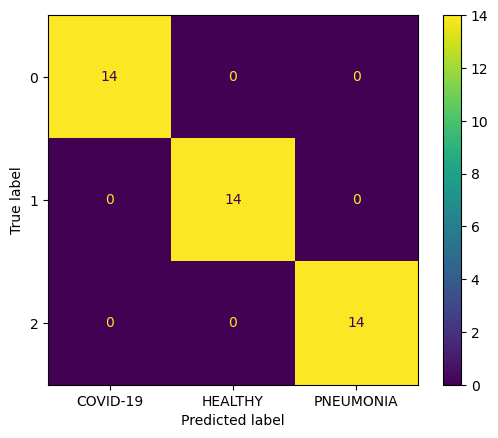

In [59]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.xticks(range(3), val_ds.class_names)
plt.show()

In [215]:
cnn_model.save('models/cnn.keras')

## RGB

Same example as before, but working with RGB images instead.

In this case, we just need to specify we are receiving an input of (256, 256, 3).

In [7]:
train_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/train/', seed=42)
val_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/validation/', seed=42)
test_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/test/', seed=42)

Found 339 files belonging to 3 classes.
Found 42 files belonging to 3 classes.
Found 45 files belonging to 3 classes.


In [51]:
cnn_rgb_model = Sequential([
    Input(shape=(256, 256, 3)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=5, strides=1, activation='relu'),
    MaxPooling2D(pool_size=3),
    Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

cnn_rgb_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [52]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_rgb_model.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=100, batch_size=32, callbacks=[es])

Epoch 1/100
11/11 [==============================] - 8s 557ms/step - loss: 1.0027 - accuracy: 0.4631 - val_loss: 0.8615 - val_accuracy: 0.8333
Epoch 2/100
11/11 [==============================] - 7s 525ms/step - loss: 0.7627 - accuracy: 0.7729 - val_loss: 0.8182 - val_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 7s 540ms/step - loss: 0.6639 - accuracy: 0.6785 - val_loss: 0.5593 - val_accuracy: 0.7619
Epoch 4/100
11/11 [==============================] - 7s 560ms/step - loss: 0.4907 - accuracy: 0.8437 - val_loss: 0.4603 - val_accuracy: 0.8571
Epoch 5/100
11/11 [==============================] - 8s 604ms/step - loss: 0.4072 - accuracy: 0.8702 - val_loss: 0.3656 - val_accuracy: 0.9286
Epoch 6/100
11/11 [==============================] - 8s 619ms/step - loss: 0.3385 - accuracy: 0.9027 - val_loss: 0.3170 - val_accuracy: 0.9524
Epoch 7/100
11/11 [==============================] - 8s 614ms/step - loss: 0.2864 - accuracy: 0.9233 - val_loss: 0.2670 - val_accuracy: 0.9048

In [53]:
loss, acc = cnn_rgb_model.evaluate(val_rgb_ds, verbose=0)
print('Validation accuracy:', round(acc, 2))

Validation accuracy: 1.0


In [54]:
cnn_rgb_model.save('models/cnn_rgb.keras')

## KerasTuner

In this section I don't perform any intensive search. It is just here so you get the idea. You can make it as complicated and deep as you want.

In [103]:
import keras_tuner as kt

In [204]:
def model_builder(hp):
    hp_filts_1 = hp.Int('n_kernels_1', min_value=8, max_value=64, step=8)
    cnn_custom_model = Sequential([
        Input(shape=(256, 256, 3)),
        Rescaling(1./255),
        Conv2D(filters=hp_filts_1, kernel_size=5, strides=1, activation='relu'),
        MaxPooling2D(pool_size=3),
    ])

    hp_n_layers = hp.Int('n_layers', min_value=0, max_value=3, step=1)
    for i, lay in enumerate(range(hp_n_layers)):
        hp_filts_n = hp.Int(f'hp_filts_{i+1}', min_value=8, max_value=64, step=8)
        cnn_custom_model.add(Conv2D(filters=hp_filts_n, kernel_size=3, strides=1, activation='relu'))
        if hp.Boolean('maxpooling'):
            cnn_custom_model.acc(MaxPooling2D(pool_size=2))
    cnn_custom_model.add(Flatten())
    cnn_custom_model.add(Dense(64, activation='relu'))
    cnn_custom_model.add(Dense(32, activation='relu'))
    cnn_custom_model.add(Dense(len(class_names), activation='softmax'))

    hp_lr = hp.Choice('learning_rate', [0.01, 0.001, 0.0001, 0.00001])
    cnn_custom_model.compile(optimizer=Adam(learning_rate=hp_lr),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
    
    return cnn_custom_model

In [205]:
tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective="loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    project_name="helloworld",
)

In [206]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
n_kernels_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
n_kernels_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [207]:
# Random search
tuner.search(train_rgb_ds, epochs=5, batch_size=32)
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=5)[0]

Trial 10 Complete [00h 00m 25s]
loss: 0.6192677617073059

Best loss So Far: 0.1978771984577179
Total elapsed time: 00h 03m 17s


In [210]:
# Build the model with the best hp
cnn_rgb_rs = model_builder(best_hps)
cnn_rgb_rs.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 252, 252, 56)      4256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 84, 84, 56)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 395136)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                25288768  
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

In [211]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_rgb_rs.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=100, batch_size=32, callbacks=[es])

Epoch 1/100
11/11 [==============================] - 10s 756ms/step - loss: 5.4662 - accuracy: 0.3481 - val_loss: 1.0598 - val_accuracy: 0.3810
Epoch 2/100
11/11 [==============================] - 9s 732ms/step - loss: 1.0767 - accuracy: 0.4631 - val_loss: 1.0434 - val_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 9s 711ms/step - loss: 0.8147 - accuracy: 0.6962 - val_loss: 0.5801 - val_accuracy: 0.8571
Epoch 4/100
11/11 [==============================] - 10s 810ms/step - loss: 0.4197 - accuracy: 0.8466 - val_loss: 1.6162 - val_accuracy: 0.4048
Epoch 5/100
11/11 [==============================] - 8s 705ms/step - loss: 0.3115 - accuracy: 0.8850 - val_loss: 0.4036 - val_accuracy: 0.8333
Epoch 6/100
11/11 [==============================] - 8s 703ms/step - loss: 0.1693 - accuracy: 0.9528 - val_loss: 0.4273 - val_accuracy: 0.8095
Epoch 7/100
11/11 [==============================] - 9s 734ms/step - loss: 0.2438 - accuracy: 0.8997 - val_loss: 0.4645 - val_accuracy: 0.76

In [212]:
loss, acc = cnn_rgb_rs.evaluate(val_rgb_ds, verbose=0)
print('Validation accuracy:', round(acc, 2))

Validation accuracy: 0.98


In [221]:
cnn_rgb_rs.save('models/cnn_rgb_rs.keras')

## Data augmentation

### Sample

In [83]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.05),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
  tf.keras.layers.RandomBrightness(0.15),
])

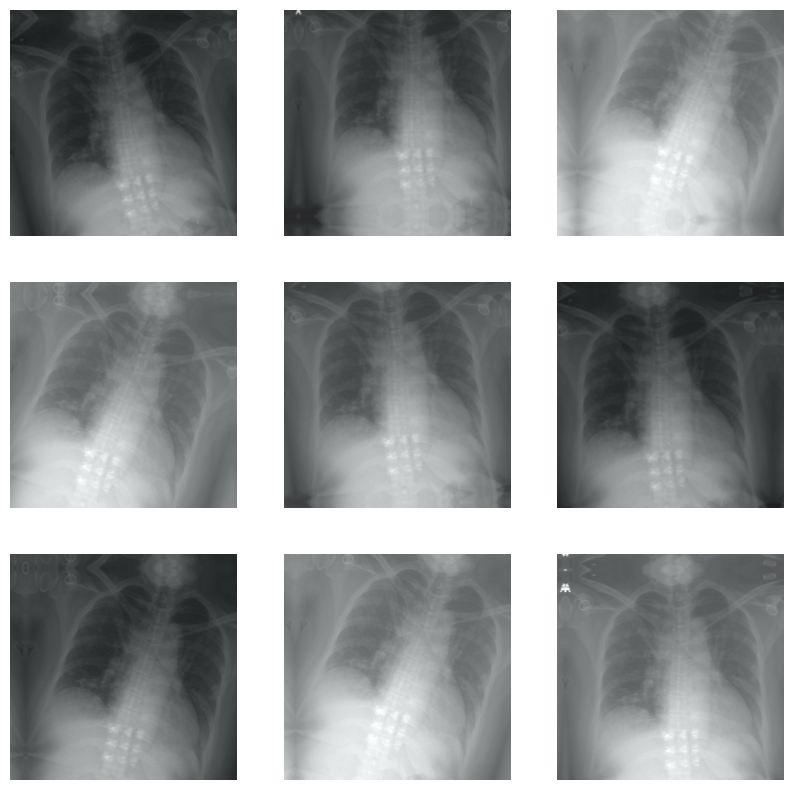

In [84]:
for image, _ in train_rgb_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255, cmap='gray')
    plt.axis('off')

### Model

Training a new model from scratch adding rotations to the images.

As you can see, it is more difficult to train when applying transformations.

We would need a more complex network or more training time.

In [18]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [21]:
cnn_rgb_augm_model = Sequential([
    Input(shape=(256, 256, 3)),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    tf.keras.layers.RandomBrightness(0.15),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=5, strides=1, activation='relu'),
    Conv2D(filters=16, kernel_size=4, strides=1, activation='relu'),
    MaxPooling2D(pool_size=3),
    Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

cnn_rgb_augm_model.compile(optimizer=Adam(learning_rate=0.0001),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

In [22]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_rgb_augm_model.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=100, batch_size=128, callbacks=[es])

Epoch 1/100
11/11 [==============================] - 27s 2s/step - loss: 1.0978 - accuracy: 0.3953 - val_loss: 1.0599 - val_accuracy: 0.6190
Epoch 2/100
11/11 [==============================] - 25s 2s/step - loss: 1.0307 - accuracy: 0.6047 - val_loss: 0.9300 - val_accuracy: 0.6429
Epoch 3/100
11/11 [==============================] - 26s 2s/step - loss: 0.8929 - accuracy: 0.6903 - val_loss: 0.7706 - val_accuracy: 0.5952
Epoch 4/100
11/11 [==============================] - 24s 2s/step - loss: 0.7502 - accuracy: 0.6608 - val_loss: 0.6012 - val_accuracy: 0.8095
Epoch 5/100
11/11 [==============================] - 24s 2s/step - loss: 0.6465 - accuracy: 0.6844 - val_loss: 0.6663 - val_accuracy: 0.6429
Epoch 6/100
11/11 [==============================] - 24s 2s/step - loss: 0.6071 - accuracy: 0.7404 - val_loss: 0.5290 - val_accuracy: 0.7381
Epoch 7/100
11/11 [==============================] - 24s 2s/step - loss: 0.4989 - accuracy: 0.8053 - val_loss: 0.4517 - val_accuracy: 0.8333
Epoch 8/100
1

In [23]:
loss, acc = cnn_rgb_augm_model.evaluate(val_rgb_ds, verbose=0)
print('Validation accuracy:', round(acc, 2))

Validation accuracy: 0.95


In [24]:
cnn_rgb_augm_model.save('models/cnn_rgb_augm.keras')

### Trick

Instead of training a new network with data augmentation from scratch, load a previously trained NN (with the original data) and train it again with image transformations.

As with the loaded model we had a good performance, a good decision can be to freeze (make non-trainable) the convolutional layers and add new and trainable ones.

In [224]:
# Load first layers of a trained model (up to the -6 layer)
cnn_rgb_augm_base = tf.keras.models.load_model("cnn_rgb.keras")
cnn_rgb_augm_base = tf.keras.models.Model(inputs=cnn_rgb_augm_base.inputs,
                                            outputs=cnn_rgb_augm_base.layers[-6].output)
# Freeze all layers
for layer in cnn_rgb_augm_base.layers:
    layer.trainable = False

cnn_rgb_augm_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_16 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 84, 84, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 82, 82, 32)        4640      
                                                                 
Total params: 5856 (22.88 KB)
Trainable params: 5856 (22.88 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

In [226]:
# Create a new sequential model
cnn_rgb_augm_model2 = Sequential([
    # Input(shape=(256, 256, 1)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    tf.keras.layers.RandomBrightness(0.15),
])

# Add previously trained model
cnn_rgb_augm_model2.add(cnn_rgb_augm_base)

# Add custom layers
cnn_rgb_augm_model2.add(Conv2D(32, kernel_size=3))
cnn_rgb_augm_model2.add(Conv2D(32, kernel_size=3))
cnn_rgb_augm_model2.add(MaxPooling2D(2))
cnn_rgb_augm_model2.add(Flatten())
cnn_rgb_augm_model2.add(Dense(64, activation='relu'))
cnn_rgb_augm_model2.add(Dense(len(class_names), activation='softmax'))

# Compile the model
cnn_rgb_augm_model2.compile(optimizer=Adam(learning_rate=0.001),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

In [227]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cnn_rgb_augm_model2.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=100, batch_size=128, callbacks=[es])

Epoch 1/100


11/11 [==============================] - 4s 178ms/step - loss: 3.6094 - accuracy: 0.3363 - val_loss: 1.7597 - val_accuracy: 0.4286
Epoch 2/100
11/11 [==============================] - 3s 174ms/step - loss: 1.4168 - accuracy: 0.5133 - val_loss: 0.6749 - val_accuracy: 0.5952
Epoch 3/100
11/11 [==============================] - 3s 173ms/step - loss: 0.8963 - accuracy: 0.6165 - val_loss: 0.7158 - val_accuracy: 0.6190
Epoch 4/100
11/11 [==============================] - 3s 173ms/step - loss: 0.6258 - accuracy: 0.7109 - val_loss: 0.6854 - val_accuracy: 0.6190
Epoch 5/100
11/11 [==============================] - 3s 170ms/step - loss: 0.5583 - accuracy: 0.7257 - val_loss: 0.8395 - val_accuracy: 0.6190
Epoch 6/100
11/11 [==============================] - 3s 177ms/step - loss: 0.5276 - accuracy: 0.7640 - val_loss: 0.4023 - val_accuracy: 0.8095
Epoch 7/100
11/11 [==============================] - 3s 175ms/step - loss: 0.5675 - accuracy: 0.7375 - val_loss: 0.7409 - val_accuracy: 0.6190
Epoch 8/100

In [228]:
loss, acc = cnn_rgb_augm_model2.evaluate(val_rgb_ds, verbose=0)
print('Validation accuracy:', round(acc, 2))

Validation accuracy: 0.95


In [229]:
cnn_rgb_augm_model2.save('models/cnn_rgb_augm_2.keras')

### Comparison on augmented data

What happens if we compare the performance on augmented data of the models trained and not trained with augmented data?

The model was trained with rotations of up 0.05 and brightness of 0.1. Let's try to put a bit more pressure and test the generalization with unseen rotations (up to 0.1) and unseen brightness (up to 0.2) changes.

In [73]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomBrightness(0.2),
])

In [74]:
# Crate new augmented dataset

new_valid_images = []
new_valid_labels = []
for images, labels in train_rgb_ds.take(1):
  for image, label in zip(images, labels):
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    new_valid_images.append(augmented_image[0])
    new_valid_labels.append(label)

Although the model trained with augmentation performs a bit worse on the real validation set, it performs much better on augmented data:

In [113]:
# Model trained without augmentation
loss, acc = cnn_rgb_model.evaluate(np.array(new_valid_images), np.array(new_valid_labels), verbose=0)
print('Normal RGB model')
print('New validation accuracy:', round(acc, 2))
print()

loss, acc = cnn_rgb_augm_model.evaluate(np.array(new_valid_images), np.array(new_valid_labels), verbose=0)
print('Augmented RGB model')
print('New validation accuracy:', round(acc, 2))

Normal RGB model
New test accuracy: 0.78

Augmented RGB model
New test accuracy: 0.94


## Transfer learning

In [88]:
from tensorflow.keras.applications import MobileNetV2

In [89]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    # Not the default size, but we can use it anyway
    input_shape=(256, 256, 3))

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

In [104]:
# Create a new sequential model
cnn_transf = Sequential()
cnn_transf.add(Input(shape=(256, 256, 3)))
cnn_transf.add(Rescaling(1./255))

# Add all the MobileNetV2 layers
cnn_transf.add(base_model)

# Add your custom layers
cnn_transf.add(Conv2D(32, kernel_size=2))
cnn_transf.add(Conv2D(32, kernel_size=3))
# cnn_transf.add(Conv2D(32, kernel_size=3))
# cnn_transf.add(MaxPooling2D(pool_size=2))
cnn_transf.add(Conv2D(32, kernel_size=3))
cnn_transf.add(Dropout(0.1))
cnn_transf.add(MaxPooling2D(pool_size=2))
cnn_transf.add(Flatten())
cnn_transf.add(Dense(64, activation='relu'))
cnn_transf.add(Dense(32, activation='relu'))
cnn_transf.add(Dense(len(class_names), activation='softmax'))

# Compile the model
cnn_transf.compile(optimizer=Adam(learning_rate=0.00005),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [105]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_transf.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=100, batch_size=64, callbacks=[es])

Epoch 1/100
11/11 [==============================] - 12s 716ms/step - loss: 1.7718 - accuracy: 0.3422 - val_loss: 1.1442 - val_accuracy: 0.4762
Epoch 2/100
11/11 [==============================] - 9s 734ms/step - loss: 1.0096 - accuracy: 0.5693 - val_loss: 0.7790 - val_accuracy: 0.5238
Epoch 3/100
11/11 [==============================] - 10s 759ms/step - loss: 0.7375 - accuracy: 0.6726 - val_loss: 0.5964 - val_accuracy: 0.6667
Epoch 4/100
11/11 [==============================] - 9s 697ms/step - loss: 0.5635 - accuracy: 0.7699 - val_loss: 0.5014 - val_accuracy: 0.7857
Epoch 5/100
11/11 [==============================] - 9s 702ms/step - loss: 0.4715 - accuracy: 0.8437 - val_loss: 0.4484 - val_accuracy: 0.8333
Epoch 6/100
11/11 [==============================] - 9s 708ms/step - loss: 0.3862 - accuracy: 0.8673 - val_loss: 0.4004 - val_accuracy: 0.8810
Epoch 7/100
11/11 [==============================] - 9s 691ms/step - loss: 0.3197 - accuracy: 0.8938 - val_loss: 0.3513 - val_accuracy: 0.88

In [106]:
loss, acc = cnn_transf.evaluate(val_rgb_ds, verbose=0)
print('Validation accuracy:', round(acc, 2))

Validation accuracy: 0.93


In [107]:
cnn_transf.save('models/cnn_rgb_transf.keras')

# Test

In [108]:
cnn_rgb_model = tf.keras.models.load_model("models/cnn_rgb.keras")
cnn_rgb_augm_model = tf.keras.models.load_model("models/cnn_rgb_augm.keras")
cnn_transf = tf.keras.models.load_model("models/cnn_rgb_transf.keras")

In [110]:
loss, acc = cnn_rgb_model.evaluate(test_rgb_ds, verbose=0)
print('Normal RGB model')
print('Test accuracy:', round(acc, 2))
print()

loss, acc = cnn_rgb_augm_model.evaluate(test_rgb_ds, verbose=0)
print('Augmented RGB model')
print('Test accuracy:', round(acc, 2))
print()

loss, acc = cnn_transf.evaluate(test_rgb_ds, verbose=0)
print('Transfer RGB model')
print('Test accuracy:', round(acc, 2))

Normal RGB model
Test accuracy: 0.93

Augmented RGB model
Test accuracy: 0.91

Transfer RGB model
Test accuracy: 0.91
